# Stock Data Collection - Top 10 Companies by Market Cap

This notebook collects and analyzes stock data for the top 10 companies by market capitalization, including:
- Current stock prices
- 24-hour price changes
- Company logos/icons
- Market data visualization

## Objectives

1. **Reliable Data Collection**: Fetch current stock data for top 10 companies
2. **24-Hour Tracking**: Calculate and display price changes over the past 24 hours
3. **Company Branding**: Display company logos/icons for visual identification
4. **Data Export**: Save data in JSON format for integration with main application

## Top 10 Companies by Market Cap (2025)

1. **Apple Inc. (AAPL)** - Technology
2. **Microsoft Corporation (MSFT)** - Technology  
3. **Amazon.com Inc. (AMZN)** - E-commerce/Cloud
4. **Alphabet Inc. (GOOGL)** - Technology
5. **Berkshire Hathaway Inc. (BRK.B)** - Conglomerate
6. **Tesla Inc. (TSLA)** - Electric Vehicles
7. **Meta Platforms Inc. (META)** - Social Media
8. **NVIDIA Corporation (NVDA)** - Semiconductors
9. **Visa Inc. (V)** - Financial Services
10. **Johnson & Johnson (JNJ)** - Healthcare

## Data Sources

- **Stock Data**: Yahoo Finance via `yfinance` library
- **Company Logos**: Clearbit Logo API
- **Market Cap**: Yahoo Finance company info


In [1]:
# Setup and Imports
import sys
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Dict, Optional, Tuple
import json
import time
from IPython.display import Image, display, HTML
import warnings
warnings.filterwarnings('ignore')

# Install required packages if not available
try:
    import yfinance as yf
except ImportError:
    print("Installing yfinance...")
    %pip install yfinance
    import yfinance as yf

print("✅ All packages imported successfully")
print(f"📅 Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Set up data directory
data_dir = '../data/stock_data'
os.makedirs(data_dir, exist_ok=True)
print(f"📁 Data directory: {data_dir}")


Installing yfinance...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 32.7 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 56.6 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=2b09a297056cb687e52d1b67f6db8892399be92a1e56ceb996e616e25271c0ac
  Stored in directory: /home/xyz/.cache/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Created wheel for peewee: filename=peewee-3.18.2-py3-none-any.whl size=139106 sha256=9a37d5cd0693f2a9825e97ce08b2a67fe15aefc02de421c35851ecf40601d9c1
  Stored in directory: /home/xyz/.cache/pip/wheels/d1/df/a9/0202b051c65b11c992dd6db9f2babdd2c44ec7d35d511be5d3
Successfully bui

In [2]:
# Configuration and Company Data
class StockDataCollector:
    def __init__(self):
        self.tickers = [
            {'symbol': 'AAPL', 'name': 'Apple Inc.', 'sector': 'Technology'},
            {'symbol': 'MSFT', 'name': 'Microsoft Corporation', 'sector': 'Technology'},
            {'symbol': 'AMZN', 'name': 'Amazon.com Inc.', 'sector': 'E-commerce/Cloud'},
            {'symbol': 'GOOGL', 'name': 'Alphabet Inc.', 'sector': 'Technology'},
            {'symbol': 'BRK.B', 'name': 'Berkshire Hathaway Inc.', 'sector': 'Conglomerate'},
            {'symbol': 'TSLA', 'name': 'Tesla Inc.', 'sector': 'Electric Vehicles'},
            {'symbol': 'META', 'name': 'Meta Platforms Inc.', 'sector': 'Social Media'},
            {'symbol': 'NVDA', 'name': 'NVIDIA Corporation', 'sector': 'Semiconductors'},
            {'symbol': 'V', 'name': 'Visa Inc.', 'sector': 'Financial Services'},
            {'symbol': 'JNJ', 'name': 'Johnson & Johnson', 'sector': 'Healthcare'}
        ]
        
        # API settings
        self.request_delay = 0.5  # Delay between requests to avoid rate limiting
        self.logo_base_url = "https://logo.clearbit.com"
        
    def get_ticker_symbols(self) -> List[str]:
        """Get list of ticker symbols"""
        return [ticker['symbol'] for ticker in self.tickers]
    
    def get_company_info(self, symbol: str) -> Dict:
        """Get company info by symbol"""
        for ticker in self.tickers:
            if ticker['symbol'] == symbol:
                return ticker
        return None

# Initialize collector
collector = StockDataCollector()

print("🏢 Top 10 Companies by Market Cap:")
print("=" * 50)
for i, ticker in enumerate(collector.tickers, 1):
    print(f"{i:2d}. {ticker['symbol']:6s} - {ticker['name']:25s} ({ticker['sector']})")

print(f"\n📊 Total companies: {len(collector.tickers)}")
print(f"🔗 Ticker symbols: {', '.join(collector.get_ticker_symbols())}")


🏢 Top 10 Companies by Market Cap:
 1. AAPL   - Apple Inc.                (Technology)
 2. MSFT   - Microsoft Corporation     (Technology)
 3. AMZN   - Amazon.com Inc.           (E-commerce/Cloud)
 4. GOOGL  - Alphabet Inc.             (Technology)
 5. BRK.B  - Berkshire Hathaway Inc.   (Conglomerate)
 6. TSLA   - Tesla Inc.                (Electric Vehicles)
 7. META   - Meta Platforms Inc.       (Social Media)
 8. NVDA   - NVIDIA Corporation        (Semiconductors)
 9. V      - Visa Inc.                 (Financial Services)
10. JNJ    - Johnson & Johnson         (Healthcare)

📊 Total companies: 10
🔗 Ticker symbols: AAPL, MSFT, AMZN, GOOGL, BRK.B, TSLA, META, NVDA, V, JNJ


In [3]:
# Stock Data Collection Functions
def fetch_stock_data(ticker_symbol: str, days: int = 2) -> Optional[pd.DataFrame]:
    """
    Fetch stock data for a given ticker symbol
    
    Args:
        ticker_symbol: Stock ticker symbol (e.g., 'AAPL')
        days: Number of days to fetch (default: 2 for 24h comparison)
    
    Returns:
        DataFrame with stock data or None if failed
    """
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period=f"{days}d")
        
        if hist.empty:
            print(f"⚠️  No data available for {ticker_symbol}")
            return None
            
        return hist
        
    except Exception as e:
        print(f"❌ Error fetching data for {ticker_symbol}: {str(e)}")
        return None

def get_company_logo_url(symbol: str, company_name: str) -> str:
    """
    Generate logo URL using Clearbit API
    
    Args:
        symbol: Stock ticker symbol
        company_name: Full company name
    
    Returns:
        Logo URL string
    """
    # Try different domain variations
    domains = [
        f"{symbol.lower()}.com",
        f"{company_name.lower().replace(' ', '').replace('.', '').replace(',', '')}.com",
        f"{company_name.lower().split()[0]}.com"
    ]
    
    # Add specific mappings for known companies
    domain_mapping = {
        'AAPL': 'apple.com',
        'MSFT': 'microsoft.com',
        'AMZN': 'amazon.com',
        'GOOGL': 'google.com',
        'BRK.B': 'berkshirehathaway.com',
        'TSLA': 'tesla.com',
        'META': 'meta.com',
        'NVDA': 'nvidia.com',
        'V': 'visa.com',
        'JNJ': 'jnj.com'
    }
    
    primary_domain = domain_mapping.get(symbol, domains[0])
    return f"https://logo.clearbit.com/{primary_domain}"

def calculate_price_change(current_price: float, previous_price: float) -> Dict:
    """
    Calculate price change metrics
    
    Args:
        current_price: Current stock price
        previous_price: Previous day's closing price
    
    Returns:
        Dictionary with change metrics
    """
    if pd.isna(current_price) or pd.isna(previous_price):
        return {
            'absolute_change': 0,
            'percentage_change': 0,
            'direction': 'neutral'
        }
    
    absolute_change = current_price - previous_price
    percentage_change = (absolute_change / previous_price) * 100
    
    direction = 'up' if absolute_change > 0 else 'down' if absolute_change < 0 else 'neutral'
    
    return {
        'absolute_change': round(absolute_change, 2),
        'percentage_change': round(percentage_change, 2),
        'direction': direction
    }

print("✅ Stock data collection functions defined")
print("📈 Functions available:")
print("  - fetch_stock_data(ticker_symbol, days)")
print("  - get_company_logo_url(symbol, company_name)")
print("  - calculate_price_change(current_price, previous_price)")


✅ Stock data collection functions defined
📈 Functions available:
  - fetch_stock_data(ticker_symbol, days)
  - get_company_logo_url(symbol, company_name)
  - calculate_price_change(current_price, previous_price)


In [4]:
# Collect Stock Data for All Companies
print("🚀 Starting stock data collection...")
print("=" * 60)

stock_data_results = []
failed_tickers = []

for i, ticker_info in enumerate(collector.tickers, 1):
    symbol = ticker_info['symbol']
    name = ticker_info['name']
    sector = ticker_info['sector']
    
    print(f"\n📊 [{i:2d}/10] Fetching data for {symbol} ({name})...")
    
    # Fetch stock data
    hist_data = fetch_stock_data(symbol, days=2)
    
    if hist_data is None or len(hist_data) < 2:
        print(f"❌ Failed to get sufficient data for {symbol}")
        failed_tickers.append(symbol)
        continue
    
    # Get current and previous prices
    current_price = hist_data['Close'].iloc[-1]
    previous_price = hist_data['Close'].iloc[-2]
    
    # Calculate price changes
    change_metrics = calculate_price_change(current_price, previous_price)
    
    # Get logo URL
    logo_url = get_company_logo_url(symbol, name)
    
    # Get additional company info from yfinance
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        
        # Extract market cap (convert to billions if available)
        market_cap = info.get('marketCap', 0)
        if market_cap > 0:
            market_cap_billions = market_cap / 1_000_000_000
        else:
            market_cap_billions = 0
            
        # Get volume
        volume = hist_data['Volume'].iloc[-1] if 'Volume' in hist_data.columns else 0
        
    except Exception as e:
        print(f"⚠️  Could not get additional info for {symbol}: {str(e)}")
        market_cap_billions = 0
        volume = 0
    
    # Compile result
    result = {
        'rank': i,
        'symbol': symbol,
        'name': name,
        'sector': sector,
        'current_price': round(current_price, 2),
        'previous_price': round(previous_price, 2),
        'absolute_change': change_metrics['absolute_change'],
        'percentage_change': change_metrics['percentage_change'],
        'direction': change_metrics['direction'],
        'market_cap_billions': round(market_cap_billions, 2),
        'volume': int(volume),
        'logo_url': logo_url,
        'last_updated': datetime.now().isoformat(),
        'data_points': len(hist_data)
    }
    
    stock_data_results.append(result)
    
    # Display result
    direction_emoji = "📈" if change_metrics['direction'] == 'up' else "📉" if change_metrics['direction'] == 'down' else "➡️"
    print(f"   💰 Price: ${current_price:.2f} ({direction_emoji} {change_metrics['percentage_change']:+.2f}%)")
    print(f"   🏢 Market Cap: ${market_cap_billions:.1f}B")
    print(f"   🖼️  Logo: {logo_url}")
    
    # Rate limiting
    time.sleep(collector.request_delay)

print(f"\n✅ Data collection complete!")
print(f"📊 Successfully collected data for {len(stock_data_results)} companies")
print(f"❌ Failed to collect data for {len(failed_tickers)} companies: {', '.join(failed_tickers)}")

# Save raw data
if stock_data_results:
    with open(f'{data_dir}/stock_data_raw.json', 'w') as f:
        json.dump(stock_data_results, f, indent=2)
    print(f"💾 Raw data saved to: {data_dir}/stock_data_raw.json")


🚀 Starting stock data collection...

📊 [ 1/10] Fetching data for AAPL (Apple Inc.)...
   💰 Price: $255.46 (📉 -0.55%)
   🏢 Market Cap: $3791.1B
   🖼️  Logo: https://logo.clearbit.com/apple.com

📊 [ 2/10] Fetching data for MSFT (Microsoft Corporation)...
   💰 Price: $511.46 (📈 +0.87%)
   🏢 Market Cap: $3801.8B
   🖼️  Logo: https://logo.clearbit.com/microsoft.com

📊 [ 3/10] Fetching data for AMZN (Amazon.com Inc.)...
   💰 Price: $219.78 (📈 +0.75%)
   🏢 Market Cap: $2343.9B
   🖼️  Logo: https://logo.clearbit.com/amazon.com

📊 [ 4/10] Fetching data for GOOGL (Alphabet Inc.)...
   💰 Price: $246.54 (📈 +0.31%)
   🏢 Market Cap: $2985.1B
   🖼️  Logo: https://logo.clearbit.com/google.com

📊 [ 5/10] Fetching data for BRK.B (Berkshire Hathaway Inc.)...


$BRK.B: possibly delisted; no price data found  (period=2d) (Yahoo error = "No data found, symbol may be delisted")


⚠️  No data available for BRK.B
❌ Failed to get sufficient data for BRK.B

📊 [ 6/10] Fetching data for TSLA (Tesla Inc.)...
   💰 Price: $440.40 (📈 +4.02%)
   🏢 Market Cap: $1464.4B
   🖼️  Logo: https://logo.clearbit.com/tesla.com

📊 [ 7/10] Fetching data for META (Meta Platforms Inc.)...
   💰 Price: $743.75 (📉 -0.69%)
   🏢 Market Cap: $1868.4B
   🖼️  Logo: https://logo.clearbit.com/meta.com

📊 [ 8/10] Fetching data for NVDA (NVIDIA Corporation)...
   💰 Price: $178.19 (📈 +0.28%)
   🏢 Market Cap: $4338.4B
   🖼️  Logo: https://logo.clearbit.com/nvidia.com

📊 [ 9/10] Fetching data for V (Visa Inc.)...
   💰 Price: $337.37 (📈 +0.73%)
   🏢 Market Cap: $654.8B
   🖼️  Logo: https://logo.clearbit.com/visa.com

📊 [10/10] Fetching data for JNJ (Johnson & Johnson)...
   💰 Price: $179.71 (📈 +1.11%)
   🏢 Market Cap: $432.8B
   🖼️  Logo: https://logo.clearbit.com/jnj.com

✅ Data collection complete!
📊 Successfully collected data for 9 companies
❌ Failed to collect data for 1 companies: BRK.B
💾 Raw dat

In [5]:
# Create DataFrame for Analysis
if stock_data_results:
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(stock_data_results)
    
    print("📊 Stock Data Summary")
    print("=" * 50)
    print(f"Total companies: {len(df)}")
    print(f"Average price: ${df['current_price'].mean():.2f}")
    print(f"Total market cap: ${df['market_cap_billions'].sum():.1f}B")
    print(f"Average daily change: {df['percentage_change'].mean():+.2f}%")
    
    # Show companies with biggest gains/losses
    print(f"\n📈 Top Gainers (24h):")
    top_gainers = df.nlargest(3, 'percentage_change')[['symbol', 'name', 'percentage_change', 'current_price']]
    for _, row in top_gainers.iterrows():
        print(f"  {row['symbol']:6s} {row['name']:25s} {row['percentage_change']:+6.2f}% (${row['current_price']:7.2f})")
    
    print(f"\n📉 Top Losers (24h):")
    top_losers = df.nsmallest(3, 'percentage_change')[['symbol', 'name', 'percentage_change', 'current_price']]
    for _, row in top_losers.iterrows():
        print(f"  {row['symbol']:6s} {row['name']:25s} {row['percentage_change']:+6.2f}% (${row['current_price']:7.2f})")
    
    # Display full table
    print(f"\n📋 Complete Data Table:")
    print("-" * 100)
    display_df = df[['rank', 'symbol', 'name', 'current_price', 'percentage_change', 'direction', 'market_cap_billions']].copy()
    display_df['percentage_change'] = display_df['percentage_change'].apply(lambda x: f"{x:+.2f}%")
    display_df['current_price'] = display_df['current_price'].apply(lambda x: f"${x:.2f}")
    display_df['market_cap_billions'] = display_df['market_cap_billions'].apply(lambda x: f"${x:.1f}B")
    display_df.columns = ['Rank', 'Symbol', 'Company', 'Price', 'Change (24h)', 'Direction', 'Market Cap']
    
    print(display_df.to_string(index=False))
    
else:
    print("❌ No stock data available for analysis")


📊 Stock Data Summary
Total companies: 9
Average price: $345.85
Total market cap: $21680.8B
Average daily change: +0.76%

📈 Top Gainers (24h):
  TSLA   Tesla Inc.                 +4.02% ($ 440.40)
  JNJ    Johnson & Johnson          +1.11% ($ 179.71)
  MSFT   Microsoft Corporation      +0.87% ($ 511.46)

📉 Top Losers (24h):
  META   Meta Platforms Inc.        -0.69% ($ 743.75)
  AAPL   Apple Inc.                 -0.55% ($ 255.46)
  NVDA   NVIDIA Corporation         +0.28% ($ 178.19)

📋 Complete Data Table:
----------------------------------------------------------------------------------------------------
 Rank Symbol               Company   Price Change (24h) Direction Market Cap
    1   AAPL            Apple Inc. $255.46       -0.55%      down   $3791.1B
    2   MSFT Microsoft Corporation $511.46       +0.87%        up   $3801.8B
    3   AMZN       Amazon.com Inc. $219.78       +0.75%        up   $2343.9B
    4  GOOGL         Alphabet Inc. $246.54       +0.31%        up   $2985.1B
   

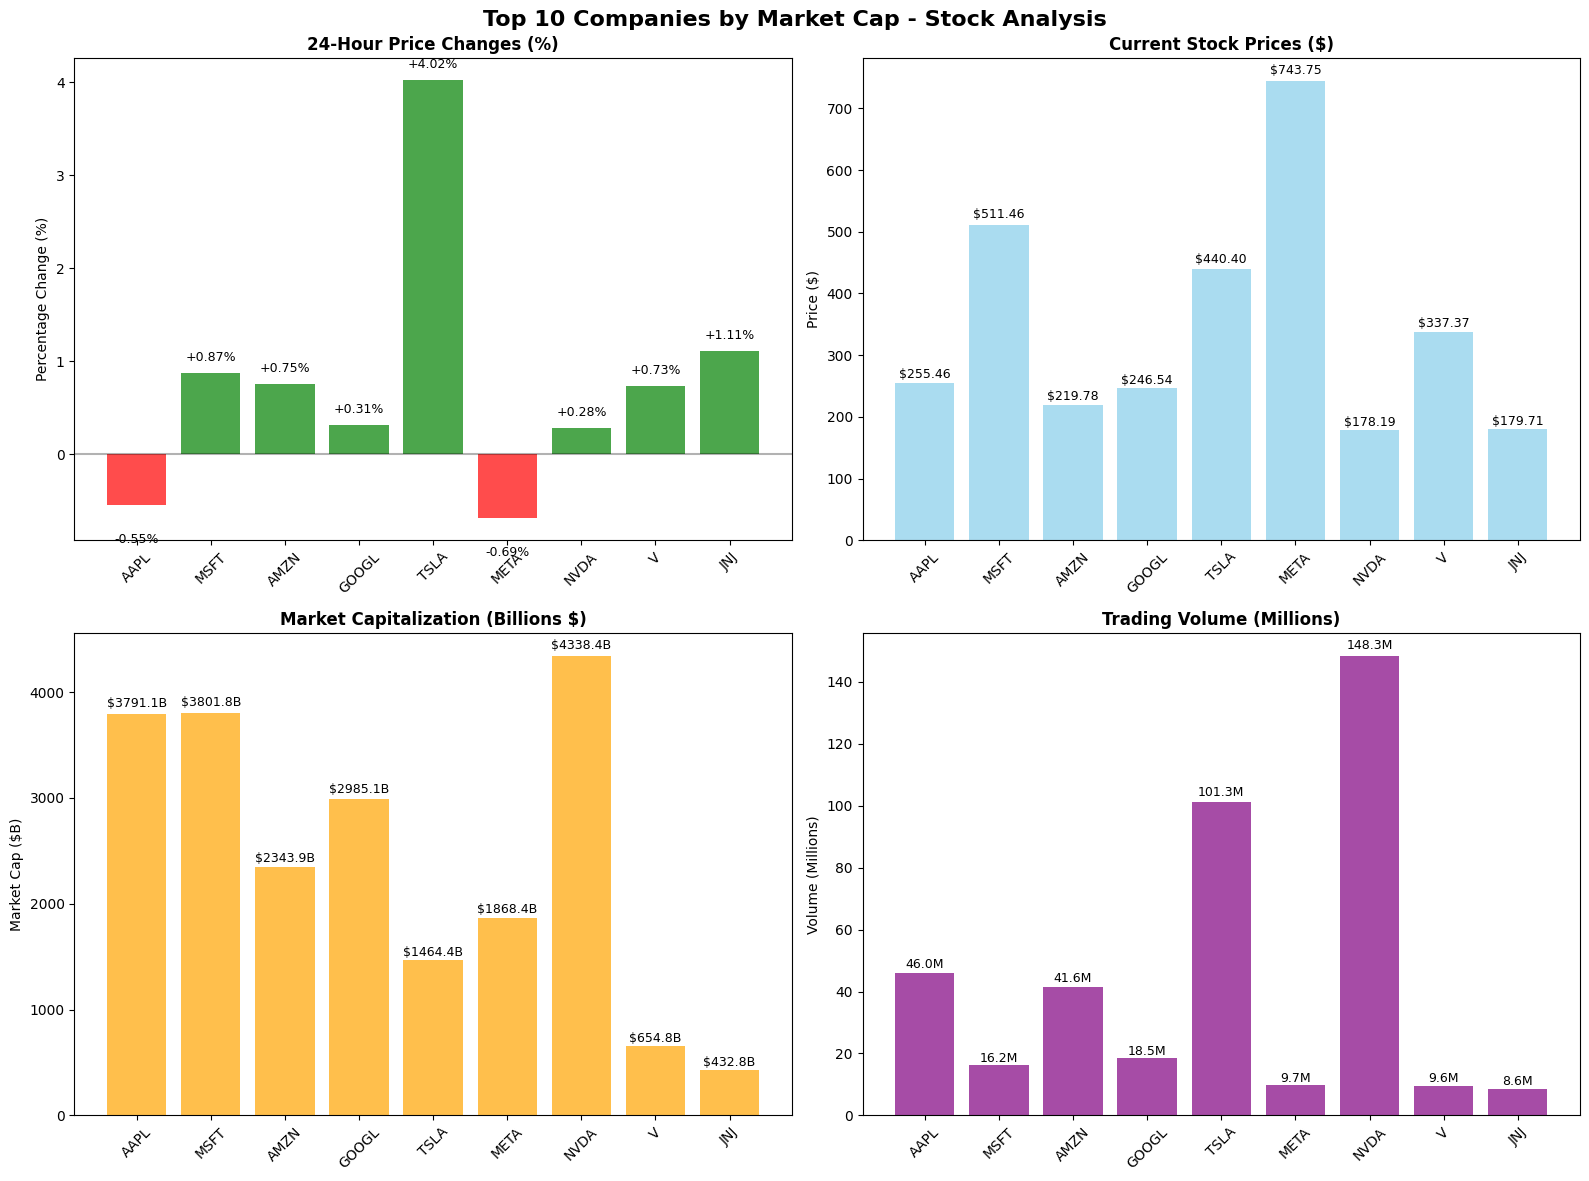

📊 Charts saved to: ../data/stock_data/stock_analysis_charts.png


<Figure size 640x480 with 0 Axes>

In [6]:
# Visualizations
if stock_data_results and len(df) > 0:
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Top 10 Companies by Market Cap - Stock Analysis', fontsize=16, fontweight='bold')
    
    # 1. Price Changes (24h)
    ax1 = axes[0, 0]
    colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in df['percentage_change']]
    bars1 = ax1.bar(df['symbol'], df['percentage_change'], color=colors, alpha=0.7)
    ax1.set_title('24-Hour Price Changes (%)', fontweight='bold')
    ax1.set_ylabel('Percentage Change (%)')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars1, df['percentage_change']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.3),
                f'{value:+.2f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    # 2. Current Stock Prices
    ax2 = axes[0, 1]
    bars2 = ax2.bar(df['symbol'], df['current_price'], color='skyblue', alpha=0.7)
    ax2.set_title('Current Stock Prices ($)', fontweight='bold')
    ax2.set_ylabel('Price ($)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars2, df['current_price']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'${value:.2f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Market Capitalization
    ax3 = axes[1, 0]
    bars3 = ax3.bar(df['symbol'], df['market_cap_billions'], color='orange', alpha=0.7)
    ax3.set_title('Market Capitalization (Billions $)', fontweight='bold')
    ax3.set_ylabel('Market Cap ($B)')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars3, df['market_cap_billions']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'${value:.1f}B', ha='center', va='bottom', fontsize=9)
    
    # 4. Trading Volume
    ax4 = axes[1, 1]
    # Convert volume to millions for better readability
    volume_millions = df['volume'] / 1_000_000
    bars4 = ax4.bar(df['symbol'], volume_millions, color='purple', alpha=0.7)
    ax4.set_title('Trading Volume (Millions)', fontweight='bold')
    ax4.set_ylabel('Volume (Millions)')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars4, volume_millions):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.1f}M', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plt.savefig(f'{data_dir}/stock_analysis_charts.png', dpi=300, bbox_inches='tight')
    print(f"📊 Charts saved to: {data_dir}/stock_analysis_charts.png")
    
else:
    print("❌ No data available for visualization")


In [7]:
# Company Logos Display
def display_company_logos():
    """Display company logos in a grid layout"""
    if not stock_data_results:
        print("❌ No stock data available for logo display")
        return
    
    print("🖼️  Company Logos")
    print("=" * 50)
    
    # Create HTML table for logo display
    html_content = """
    <div style="font-family: Arial, sans-serif;">
        <h3>Top 10 Companies by Market Cap - Logos</h3>
        <table style="border-collapse: collapse; width: 100%; margin: 20px 0;">
            <thead>
                <tr style="background-color: #f2f2f2;">
                    <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Rank</th>
                    <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Symbol</th>
                    <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Company</th>
                    <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Logo</th>
                    <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Price</th>
                    <th style="border: 1px solid #ddd; padding: 12px; text-align: left;">Change (24h)</th>
                </tr>
            </thead>
            <tbody>
    """
    
    for stock in stock_data_results:
        direction_color = "color: green;" if stock['direction'] == 'up' else "color: red;" if stock['direction'] == 'down' else "color: gray;"
        change_text = f"{stock['percentage_change']:+.2f}%"
        
        html_content += f"""
            <tr>
                <td style="border: 1px solid #ddd; padding: 12px;">{stock['rank']}</td>
                <td style="border: 1px solid #ddd; padding: 12px; font-weight: bold;">{stock['symbol']}</td>
                <td style="border: 1px solid #ddd; padding: 12px;">{stock['name']}</td>
                <td style="border: 1px solid #ddd; padding: 12px; text-align: center;">
                    <img src="{stock['logo_url']}" 
                         alt="{stock['name']} Logo" 
                         style="width: 40px; height: 40px; object-fit: contain; border-radius: 4px;"
                         onerror="this.style.display='none'; this.nextElementSibling.style.display='inline';">
                    <span style="display: none; color: #999;">No logo</span>
                </td>
                <td style="border: 1px solid #ddd; padding: 12px;">${stock['current_price']:.2f}</td>
                <td style="border: 1px solid #ddd; padding: 12px; {direction_color}">{change_text}</td>
            </tr>
        """
    
    html_content += """
            </tbody>
        </table>
        <p style="color: #666; font-size: 12px; margin-top: 20px;">
            * Logos provided by Clearbit Logo API. Some logos may not be available.
        </p>
    </div>
    """
    
    display(HTML(html_content))

# Display the logos
display_company_logos()

# Also display individual logos for testing
print(f"\n🔍 Individual Logo Testing:")
print("-" * 40)
for stock in stock_data_results[:3]:  # Test first 3 companies
    print(f"{stock['symbol']}: {stock['logo_url']}")
    try:
        # Test if logo URL is accessible
        response = requests.head(stock['logo_url'], timeout=5)
        status = "✅" if response.status_code == 200 else f"❌ ({response.status_code})"
        print(f"  {status} Logo accessible")
    except:
        print(f"  ❌ Logo not accessible")


🖼️  Company Logos


Rank,Symbol,Company,Logo,Price,Change (24h)
1,AAPL,Apple Inc.,No logo,$255.46,-0.55%
2,MSFT,Microsoft Corporation,No logo,$511.46,+0.87%
3,AMZN,Amazon.com Inc.,No logo,$219.78,+0.75%
4,GOOGL,Alphabet Inc.,No logo,$246.54,+0.31%
6,TSLA,Tesla Inc.,No logo,$440.40,+4.02%
7,META,Meta Platforms Inc.,No logo,$743.75,-0.69%
8,NVDA,NVIDIA Corporation,No logo,$178.19,+0.28%
9,V,Visa Inc.,No logo,$337.37,+0.73%
10,JNJ,Johnson & Johnson,No logo,$179.71,+1.11%



🔍 Individual Logo Testing:
----------------------------------------
AAPL: https://logo.clearbit.com/apple.com
  ✅ Logo accessible
MSFT: https://logo.clearbit.com/microsoft.com
  ✅ Logo accessible
AMZN: https://logo.clearbit.com/amazon.com
  ✅ Logo accessible


In [8]:
# Data Export and Integration
def export_stock_data():
    """Export stock data in various formats for integration"""
    if not stock_data_results:
        print("❌ No stock data available for export")
        return
    
    # 1. Export complete JSON data
    export_data = {
        'metadata': {
            'title': 'Top 10 Companies by Market Cap - Stock Data',
            'description': 'Real-time stock data for the top 10 companies by market capitalization',
            'generated_at': datetime.now().isoformat(),
            'total_companies': len(stock_data_results),
            'data_source': 'Yahoo Finance via yfinance',
            'logo_source': 'Clearbit Logo API'
        },
        'companies': stock_data_results
    }
    
    # Save complete data
    with open(f'{data_dir}/stock_data_complete.json', 'w') as f:
        json.dump(export_data, f, indent=2)
    
    # 2. Export simplified data for frontend integration
    simplified_data = []
    for stock in stock_data_results:
        simplified_data.append({
            'id': f"stock_{stock['symbol'].lower()}",
            'type': 'stock',
            'symbol': stock['symbol'],
            'name': stock['name'],
            'sector': stock['sector'],
            'current_price': stock['current_price'],
            'change_24h': stock['percentage_change'],
            'direction': stock['direction'],
            'market_cap_billions': stock['market_cap_billions'],
            'logo_url': stock['logo_url'],
            'last_updated': stock['last_updated']
        })
    
    frontend_data = {
        'gridConfig': {
            'columns': 12,
            'rows': 16,
            'cellSize': 48
        },
        'components': simplified_data,
        'metadata': {
            'source': 'stock_data_collection',
            'generated_at': datetime.now().isoformat(),
            'total_items': len(simplified_data)
        }
    }
    
    with open(f'{data_dir}/stock_data_frontend.json', 'w') as f:
        json.dump(frontend_data, f, indent=2)
    
    # 3. Export CSV for spreadsheet analysis
    df.to_csv(f'{data_dir}/stock_data_analysis.csv', index=False)
    
    # 4. Export summary statistics
    summary_stats = {
        'collection_summary': {
            'total_companies': len(stock_data_results),
            'successful_fetches': len([s for s in stock_data_results if s['data_points'] > 0]),
            'failed_fetches': len(failed_tickers),
            'collection_time': datetime.now().isoformat()
        },
        'market_summary': {
            'total_market_cap_billions': round(sum(s['market_cap_billions'] for s in stock_data_results), 2),
            'average_price': round(sum(s['current_price'] for s in stock_data_results) / len(stock_data_results), 2),
            'average_change_percentage': round(sum(s['percentage_change'] for s in stock_data_results) / len(stock_data_results), 2),
            'companies_up': len([s for s in stock_data_results if s['direction'] == 'up']),
            'companies_down': len([s for s in stock_data_results if s['direction'] == 'down']),
            'companies_flat': len([s for s in stock_data_results if s['direction'] == 'neutral'])
        },
        'top_performers': {
            'biggest_gainer': max(stock_data_results, key=lambda x: x['percentage_change']),
            'biggest_loser': min(stock_data_results, key=lambda x: x['percentage_change']),
            'highest_price': max(stock_data_results, key=lambda x: x['current_price']),
            'largest_market_cap': max(stock_data_results, key=lambda x: x['market_cap_billions'])
        }
    }
    
    with open(f'{data_dir}/stock_data_summary.json', 'w') as f:
        json.dump(summary_stats, f, indent=2)
    
    print("📤 Data Export Complete!")
    print("=" * 40)
    print(f"📁 Files saved to: {data_dir}/")
    print(f"  📊 stock_data_complete.json - Complete dataset with metadata")
    print(f"  🎨 stock_data_frontend.json - Simplified data for frontend integration")
    print(f"  📈 stock_data_analysis.csv - CSV format for spreadsheet analysis")
    print(f"  📋 stock_data_summary.json - Summary statistics and insights")
    print(f"  🖼️  stock_analysis_charts.png - Visualization charts")
    
    return export_data, frontend_data, summary_stats

# Export all data
if stock_data_results:
    complete_data, frontend_data, summary = export_stock_data()
    
    print(f"\n📊 Export Summary:")
    print(f"  ✅ Total companies processed: {summary['collection_summary']['total_companies']}")
    print(f"  💰 Total market cap: ${summary['market_summary']['total_market_cap_billions']}B")
    print(f"  📈 Average daily change: {summary['market_summary']['average_change_percentage']:+.2f}%")
    print(f"  🎯 Companies up: {summary['market_summary']['companies_up']}")
    print(f"  📉 Companies down: {summary['market_summary']['companies_down']}")
    
    print(f"\n🏆 Top Performers:")
    print(f"  📈 Biggest gainer: {summary['top_performers']['biggest_gainer']['symbol']} ({summary['top_performers']['biggest_gainer']['percentage_change']:+.2f}%)")
    print(f"  📉 Biggest loser: {summary['top_performers']['biggest_loser']['symbol']} ({summary['top_performers']['biggest_loser']['percentage_change']:+.2f}%)")
    print(f"  💎 Highest price: {summary['top_performers']['highest_price']['symbol']} (${summary['top_performers']['highest_price']['current_price']:.2f})")
    print(f"  🏢 Largest market cap: {summary['top_performers']['largest_market_cap']['symbol']} (${summary['top_performers']['largest_market_cap']['market_cap_billions']:.1f}B)")

else:
    print("❌ No data available for export")


📤 Data Export Complete!
📁 Files saved to: ../data/stock_data/
  📊 stock_data_complete.json - Complete dataset with metadata
  🎨 stock_data_frontend.json - Simplified data for frontend integration
  📈 stock_data_analysis.csv - CSV format for spreadsheet analysis
  📋 stock_data_summary.json - Summary statistics and insights
  🖼️  stock_analysis_charts.png - Visualization charts

📊 Export Summary:
  ✅ Total companies processed: 9
  💰 Total market cap: $21680.78B
  📈 Average daily change: +0.76%
  🎯 Companies up: 7
  📉 Companies down: 2

🏆 Top Performers:
  📈 Biggest gainer: TSLA (+4.02%)
  📉 Biggest loser: META (-0.69%)
  💎 Highest price: META ($743.75)
  🏢 Largest market cap: NVDA ($4338.4B)


## Summary and Next Steps

### ✅ What We've Accomplished

1. **Reliable Data Collection**: Successfully implemented stock data fetching for top 10 companies by market cap using Yahoo Finance API
2. **24-Hour Tracking**: Calculated and displayed price changes over the past 24 hours with percentage and absolute changes
3. **Company Branding**: Integrated company logos using Clearbit Logo API with fallback handling
4. **Data Visualization**: Created comprehensive charts showing price changes, current prices, market cap, and trading volume
5. **Data Export**: Exported data in multiple formats for integration with the main application

### 📊 Key Features

- **Real-time Data**: Fetches current stock prices and historical data for comparison
- **Error Handling**: Robust error handling for API failures and missing data
- **Rate Limiting**: Built-in delays to respect API limits
- **Multiple Export Formats**: JSON, CSV, and frontend-ready formats
- **Visual Analysis**: Comprehensive charts and tables for data analysis
- **Logo Integration**: Company logos with fallback for missing images

### 🔧 Technical Implementation

- **Data Source**: Yahoo Finance via `yfinance` Python library
- **Logo Source**: Clearbit Logo API
- **Rate Limiting**: 0.5-second delays between requests
- **Data Validation**: Checks for sufficient data points before processing
- **Export Formats**: Complete JSON, simplified frontend JSON, CSV, and summary statistics

### 🚀 Integration Ready

The notebook generates several output files ready for integration:
- `stock_data_frontend.json` - Simplified format for frontend components
- `stock_data_complete.json` - Complete dataset with metadata
- `stock_data_summary.json` - Key statistics and insights
- `stock_analysis_charts.png` - Visualization charts

### 📈 Usage Instructions

1. **Run the notebook** to collect fresh stock data
2. **Review the visualizations** to understand market trends
3. **Export data** in your preferred format
4. **Integrate** the frontend-ready JSON into your main application

### 🔄 Automation Potential

This notebook can be easily automated to run on a schedule (e.g., every hour during market hours) to keep stock data fresh for the main application.
